In [364]:
import pandas as pd
import io
import os
import glob
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objects as go
import plotly.express as px

def rpy2rm(roll, pitch, yaw) :
    '''
    fixed angle rotation values to rotation matrix
    same as euler angle with ZYX order
    '''
    c = np.cos
    s = np.sin
    r, p, y = roll, pitch, yaw
    Rz = np.array([
        [ c(y), -s(y), 0],
        [ s(y),  c(y), 0],
        [    0,     0, 1]
    ])
    Ry = np.array([
        [ c(p), 0, s(p)],
        [    0, 1,     0],
        [ -s(p), 0,  c(p)]
    ])
    Rx = np.array([
        [1,    0,     0],
        [0, c(r), -s(r)],
        [0, s(r),  c(r)]
    ])
    return Rz @ Ry @ Rx

def rotate(landmark, roll=0, pitch=0, yaw=0) :
    """
    input type : degree
    """

    R = rpy2rm(np.deg2rad(roll), np.deg2rad(pitch), np.deg2rad(yaw))
    return (R @ landmark.T).T


def averate_filter(arr, kernel_size=3) :
    stacked = np.vstack([
        arr[i:len(arr)-kernel_size+i+1] for i in range(kernel_size)
    ])
    return stacked.sum(axis=0) / kernel_size


def plot(
    points, connection_idx_list,
    line_color_list = None,
    show = True
) :
    '''
    points : np.ndarray
        shape : N, 2
    '''
    if not line_color_list :
        line_color_list = ['red'] * (len(connection_idx_list))

    fig = go.Figure(
        data = list(map(
            lambda i, j, c : go.Scatter(
                x = points[[i, j], 0],
                y = points[[i, j], 1],
                mode = 'lines+markers+text',
                line = dict(
                    color = c
                ),
                marker = dict(
                    color = c,
                    size = 2
                )
            ),
            connection_idx_list[:-1],
            connection_idx_list[1:],
            line_color_list
        ))
    )
    fig.update_yaxes(scaleanchor='x', scaleratio=1)

    if show :
        fig.show()

def plot3d(
    points, connection_idx_list,
    line_color_list = None,
    show = True
) :
    '''
    points : np.ndarray
        shape : N, 3
    '''
    if not line_color_list :
        line_color_list = ['red'] * (len(connection_idx_list))

    fig = go.Figure(
        data = list(map(
            lambda i, j, c : go.Scatter3d(
                x = points[[i, j], 0],
                y = points[[i, j], 1],
                z = points[[i, j], 2],
                mode = 'lines+markers+text',
                line = dict(
                    color = c
                ),
                marker = dict(
                    color = c,
                    size = 2
                )
            ),
            connection_idx_list[:-1],
            connection_idx_list[1:],
            line_color_list
        ))
    )

    max_range = np.max(np.ptp(points, axis=0))
    xmin, ymin, zmin = points.min(axis=0)

    fig.update_layout(scene=dict(aspectmode='cube'))
    fig.update_layout(scene=dict(
        xaxis = dict(range=[xmin-0.1, xmin + max_range+ 0.1]),
        yaxis = dict(range=[ymin-0.1, ymin + max_range+ 0.1]),
        zaxis = dict(range=[zmin-0.1, zmin + max_range+ 0.1])
    ))

    layout = go.Layout(
        scene = dict(
            camera = dict(
                eye = dict(x=-1, y = -1, z = 1)
            ),
            aspectmode="data"
        )
    )
    fig.layout = layout
    if show :
        fig.show()


@dataclass
class MocapLowerLandmark :
    LANK: np.ndarray = None # 0
    LASI: np.ndarray = None # 1
    LHEE: np.ndarray = None # 2
    LKNE: np.ndarray = None # 3
    LPSI: np.ndarray = None # 4
    LTHI: np.ndarray = None # 5
    LTIB: np.ndarray = None # 6
    LTOE: np.ndarray = None # 7
    RANK: np.ndarray = None # 8
    RASI: np.ndarray = None # 9
    RHEE: np.ndarray = None # 10
    RKNE: np.ndarray = None # 11
    RPSI: np.ndarray = None # 12
    RTHI: np.ndarray = None # 13
    RTIB: np.ndarray = None # 14
    RTOE: np.ndarray = None # 15
    
    CONN_PATH_LIST = [
         7,  2,  0,  3,  1,  4, 
        12,  9, 11,  8, 10, 15
    ]

    @staticmethod
    def calcKneeDegrees(mocap_df, idx = 0) :
        raw_val = mocap_df.loc[:, ~mocap_df.columns.isin(["Frame", "Time (Seconds)"]) ].to_numpy()
        raw_val = raw_val[idx].reshape(16, 3)

        rthai = raw_val[9] - raw_val[11]
        rcalf = raw_val[8] - raw_val[11]

        lthai = raw_val[1] - raw_val[3]
        lcalf = raw_val[0] - raw_val[3]

        rthai_unit = rthai / np.linalg.norm(rthai)
        rcalf_unit = rcalf / np.linalg.norm(rcalf)

        lthai_unit = lthai / np.linalg.norm(lthai)
        lcalf_unit = lcalf / np.linalg.norm(lcalf)

        rangle = np.arccos(np.dot(rthai_unit, rcalf_unit))
        langle = np.arccos(np.dot(lthai_unit, lcalf_unit))

        return langle, rangle

    @staticmethod
    def df2landmark(mocap_df, idx = 0) :
        raw_val = mocap_df.loc[:, ~mocap_df.columns.isin(["Frame", "Time (Seconds)"]) ].to_numpy()
        return raw_val[idx].reshape(16, 3)



In [374]:
def read_whole_data(trial_idx, experiment_idx) :
    FORCE_PLATE_1_PATH = f"/Volumes/HJP/CODES/mocap/data/d1/230626_Group7_trial{trial_idx}_{experiment_idx:03}_forceplate_1.csv"
    FORCE_PLATE_2_PATH = f"/Volumes/HJP/CODES/mocap/data/d1/230626_Group7_trial{trial_idx}_{experiment_idx:03}_forceplate_2.csv"
    MOCAP_PATH = f"/Volumes/HJP/CODES/mocap/data/d1/230626_Group7_trial{trial_idx}_{experiment_idx:03}.csv"
    EMG_PATH = f"/Volumes/HJP/CODES/mocap/data/d1/230626_Group7_trial{trial_idx}_{experiment_idx:03}_Trigno_2883.csv"

    
    with open(FORCE_PLATE_1_PATH, "r") as fp :
        lines = fp.readlines()
    raw_text = "".join(lines)
    table = raw_text.split("\n\n")[-1]
    fp1_df = pd.read_csv(io.StringIO(table))

    with open(FORCE_PLATE_2_PATH, "r") as fp :
        lines = fp.readlines()
    raw_text = "".join(lines)
    table = raw_text.split("\n\n")[-1]
    fp2_df = pd.read_csv(io.StringIO(table))

    with open(EMG_PATH, "r") as fp :
        lines = fp.readlines()
    raw_text = "".join(lines)
    table = raw_text.split("\n\n")[-1]
    emg_df = pd.read_csv(io.StringIO(table))

    with open(MOCAP_PATH, "r") as fp :
        lines = fp.readlines()
    mocap_df = pd.read_csv(io.StringIO( ''.join(lines[6:]) ))
    
    return mocap_df, emg_df, fp1_df, fp2_df

mocap_df, emg_df, fp1_df, fp2_df = read_whole_data(3, 0)

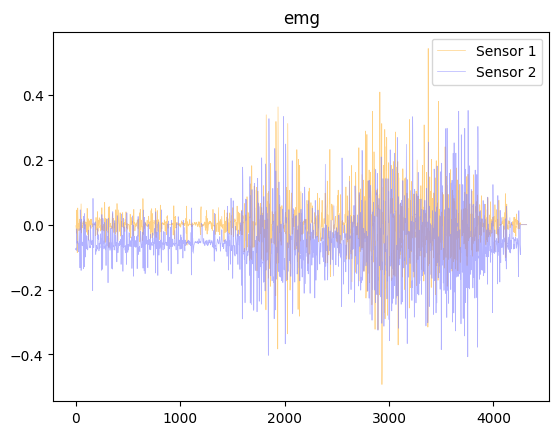

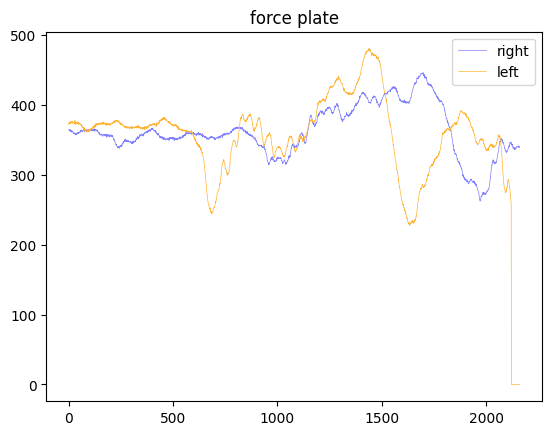

In [369]:
orange = (1.0, 0.7, 0.2)
blue = (0.5, 0.5, 1.0)

plt.plot(
    averate_filter(emg_df["Sensor 1"].to_numpy(), kernel_size=2),
    label = "Sensor 1",
    linewidth=0.5,
    color = orange,
    alpha = 0.6
)

plt.plot( 
    averate_filter(emg_df["Sensor 2"].to_numpy(), kernel_size=2),
    label = "Sensor 2",
    linewidth=0.5,
    color = blue,
    alpha = 0.6
)
plt.title("emg")
plt.legend()
plt.show()

plt.plot(fp1_df[" Fz"],
    label="right",
    linewidth=0.5,
    color = blue,
)
plt.plot(
    fp2_df[" Fz"],
    label="left",
    linewidth=0.5,
    color = orange,
)
plt.legend()
plt.title("force plate")
plt.show()

In [376]:
landmark = MocapLowerLandmark.df2landmark(mocap_df, 300)

plot3d(
    rotate(
        landmark,
        90
    ),
    MocapLowerLandmark.CONN_PATH_LIST)

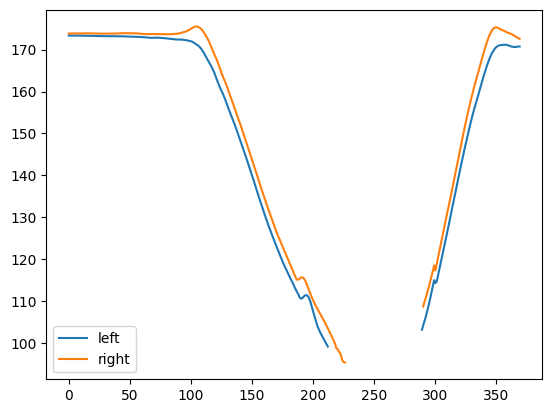

In [375]:
angle_track = list(map(
    lambda idx : calcKneeDegrees(mocap_df, idx = idx),
    range(len(mocap_df))
))

angle_track = np.array(angle_track)
rangle_track = angle_track[:, 0]
langle_track = angle_track[:, 1]

rangle_track = list(map(
    np.rad2deg,
    rangle_track
))

langle_track = list(map(
    np.rad2deg,
    langle_track
))

plt.plot(langle_track, label="left")
plt.plot(rangle_track, label="right")
plt.legend()
plt.show()

SyntaxError: can't use starred expression here (916167967.py, line 1)

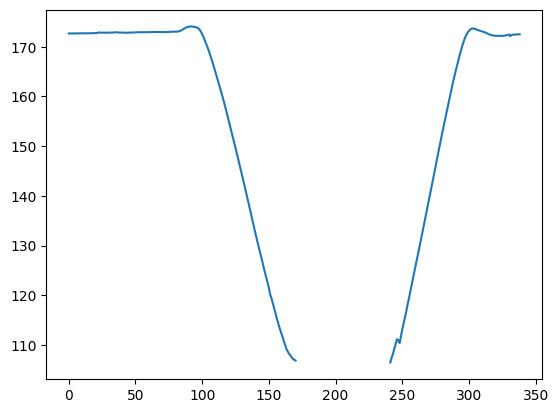

In [338]:
plt.plot(angle_track)
plt.show()

(339,)

In [325]:
len(mocap_df)

339

In [316]:
langle, rangle = MocapLowerLandmark.calcKneeDegrees(
    mocap_df, 220
)

np.rad2deg(langle), np.rad2deg(rangle)

(84.3349965307593, nan)

In [319]:

def calcKneeDegrees(mocap_df, idx = 0) :
    raw_val = mocap_df.loc[:, ~mocap_df.columns.isin(["Frame", "Time (Seconds)"]) ].to_numpy()
    raw_val = raw_val[idx].reshape(16, 3)

    rthai = raw_val[9] - raw_val[11]
    rcalf = raw_val[8] - raw_val[11]

    lthai = raw_val[1] - raw_val[3]
    lcalf = raw_val[0] - raw_val[3]

    rthai_unit = rthai / np.linalg.norm(rthai)
    rcalf_unit = rcalf / np.linalg.norm(rcalf)

    lthai_unit = lthai / np.linalg.norm(lthai)
    lcalf_unit = lcalf / np.linalg.norm(lcalf)

    rangle = np.arccos(np.dot(rthai_unit, rcalf_unit))
    langle = np.arccos(np.dot(lthai_unit, lcalf_unit))

    return langle, rangle


langle, rangle = calcKneeDegrees(mocap_df, 220)

np.rad2deg(langle), np.rad2deg(rangle)

(84.3349965307593, nan)